In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
from PIL import Image

import os
from os import listdir
from os.path import isfile, join

import string

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

os.chdir('E:/College/Final Year Project/ufi')
from utils.load_data import load_pathnames

from tqdm import tqdm_notebook as tqdmn

In [2]:
def surf(img_path):
    img = cv2.imread(img_path, 0)
    surf = cv2.xfeatures2d.SURF_create()

    # compute the descriptors
    kp, des = surf.detectAndCompute(img, None)
    
#     img_out = np.asarray(img)
#     img_out = cv2.drawKeypoints(img, kp, img)
    
#     return img_out, kp, des
    return kp, des

img, k, d = surf('data/train/s1/1.pgm')
plt.imshow(img), plt.show()


In [3]:
paths, labels = load_pathnames('data', True)

In [4]:
feature ={}
for image_path in paths:
    kp, des = surf(image_path)
    
    ii = image_path.split('\\')
    image = '-'.join((ii[2],ii[3]))
    
    feature[image] = des #Store the descriptor using the filename as key

In [5]:
MIN_MATCH_COUNT = 10

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50) 
flann = cv2.FlannBasedMatcher(index_params,search_params)


In [6]:
test_paths, test_labels = load_pathnames('data', False)

In [7]:
correct = 0

for test_path, test_label in tqdmn(zip(test_paths, test_labels)):
    kp_test, des_test = surf(test_path)
    result = {}
    for filename_train, des_train in feature.items():
        good = []
        ctr = 0
        matches = flann.knnMatch(des_train, des_test, k=2)    
        for m, n in matches:
            if (m.distance < 0.7*n.distance): #Apply the ratio test as per the paper
                good.append([m])
                ctr+=1
        result[filename_train] = ctr
    best_match = max(result,key = lambda x: result[x])
    if (best_match.split('-')[0] == ('s' + str(test_label))):
        correct += 1

acc = correct/605
print("Accuracy:", acc)


Accuracy: 0.38016528925619836


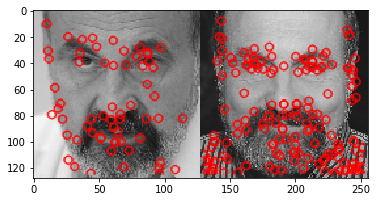

In [8]:
img1 = cv2.imread('data/test/s1/3.pgm',0) # queryImage
img2 = cv2.imread('data/train/s1/1.pgm',0) # trainImage

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# create BFMatcher object
matches = flann.knnMatch(des1,des2,k=2)

matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.imshow(img3)
plt.show()